#### Problem Description

You own a diamond business and you have to replenish your inventory. You have $5,000,000 budgeted towards the purchase of new diamonds. You have a historical list of diamonds that were purchased from various distributor vendors and the prices they retailed for. You also have a list of diamonds that are currently on the market, but this list does not include any set prices. Instead, you will place an offer for a diamond and the distributor will make a single yes-or-no decision to sell you the diamond at that price. If your offer is accepted then you receive the diamond and you will be awarded the difference between the retail price your company can eventually sell the diamond for and the price that you offered as profit. If you fail to make a purchase, you simply do not get anything for profit.

#### Evaluation

Recall that your max budget is 5 million, so the total sum of your offers needs to be less than 5 million. You will be charged the value of your offer even if the seller would have been willing to sell for less (You always pay your offer if it is accepted). If your offer is rejected for being less than the price the seller wants you pay nothing, but you don’t receive the diamond. Your profit will be calculated as the sum of retail price the diamonds will eventually sell for minus the sum of your accepted offers. You make no profit on rejected offers.


## Motivation

A friend of mine who recently graduated from university was talking to me about the types of projects he was working on as a part of his 'data analytics' course work and this one really stood out to me. I thought it was really interesting because it presented several unique issues not least of which was that it involved multiple optimization requirements. From the evaluation procedure the goal is to maximize expected profit, but also to have offers that either exceed or meet the value of the diamond. Since, we cannot guarantee the predictions will be equal to the value of the diamonds our goal will be to minimize the overage.



In [1]:

import sys
# !{sys.executable} -m pip install numpy scipy pandas seaborn matplotlib tabulate scikit-learn

import scipy
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
cmap = sns.color_palette("GnBu_r", n_colors=20)
sns.set_palette(cmap, n_colors=20)
np.set_printoptions(precision=2)

from data import transform_df, make_dummies, transcode_vars
from vis import retail_carat_scat, retail_cost_kde, build_table, \
vendor_charbars, vendor1_charbars
from ml import data_prep, fit_model, bid_math

training_data = pd.read_csv("training.csv")

## Data

#### Calculated Variables

When I looked at the raw data I immediately recognized that the dimension field needed to be subdivided and when I was looking up Table and Depth, I thought it was interesting that Depth Percent would sometimes be N/A when the dimensions were present. So I overwrote the field and replaced Depth with my own depth_pct. 

I also thought it was interesting that table width wasnt included when table percent and width exist. I thought this could be an informative feature as it is what a person first sees when they look at a diamond. 

Below are the functions I used to calculate the depth percentage and table width:

In [2]:
def _depthpct(l, w, h):
    """Calculate depth percentage"""
    # There are several instances where Depth in the dataset is N/A but the dimension is provided.
    
    if l == -1:
        depth_pct = None
    else:
        depth_pct = h/((l+w)/2)
    return depth_pct

def _tablesize(l, w, h, tab_pct):
    '''Calculate Table Width.'''
    # Calculate the width of the table when the table percent and dimensions are not NA.
    if l == -1 or tab_pct == -1:
        tabsize = None
    else:
        tabsize = tab_pct*w
    return tabsize

In [3]:
# EDA
# Apply transformations
training_copy = training_data.copy()
training_df = transform_df(training_copy)
tab = build_table(training_data)

print(tab)


  Vendor     Price    Retail    Profit    Count
--------  --------  --------  --------  -------
       1   2363.48   1240.53   3604.01     2702
       2  27123.5   12001.5   39125        3241
       3  10278.1    5014.3   15292.4      1106
       4  15725.5    3832.45  19558        1001


<module 'matplotlib.pyplot' from '/home/dismas/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

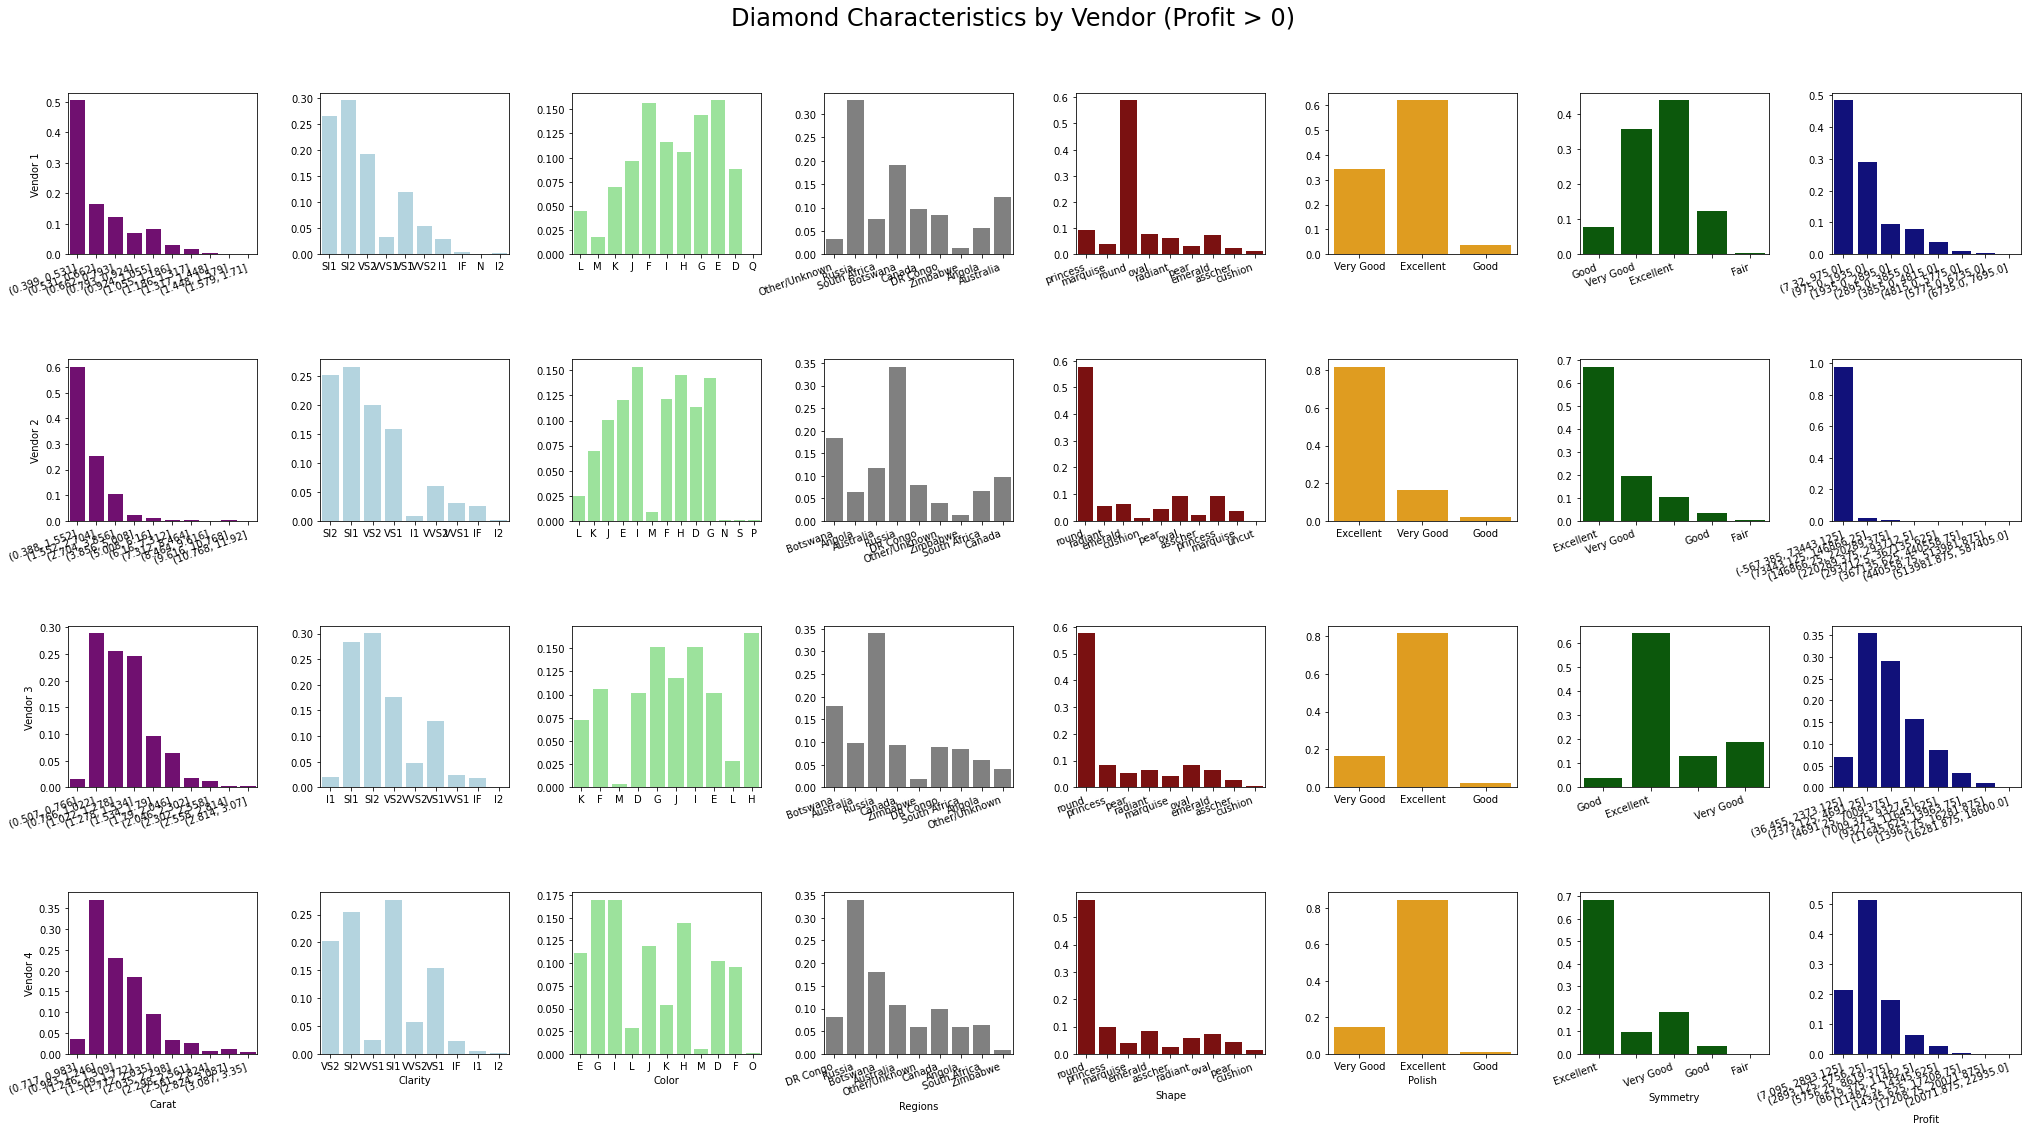

In [4]:
vendor_charbars(training_df, vendors=[1, 2, 3, 4], chars=8, max_profit=0, ttl='Diamond Characteristics by Vendor (Profit > 0)')

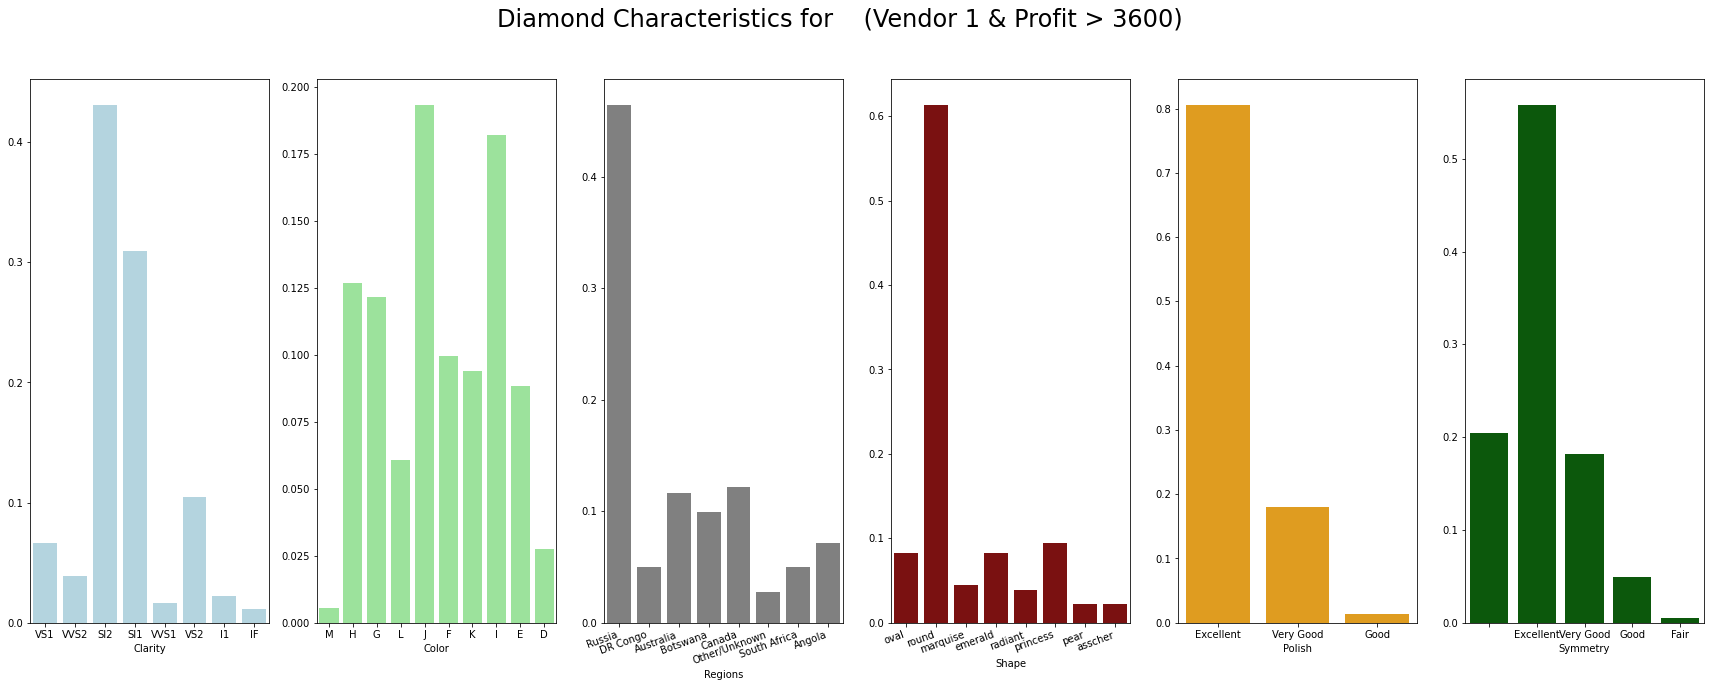

In [5]:
vendor1_charbars(training_df)

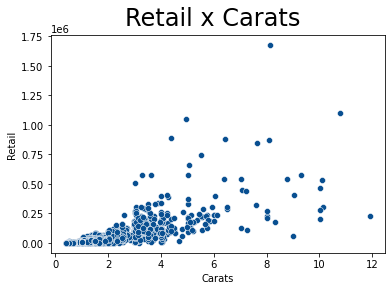

In [6]:
p=retail_carat_scat(training_df)

Vendor 1 appears to be over-charging for their diamonds, on average the profit from the diamonds purchased from Vendor 1 earn significantly less profit. Diamonds purchased through Vendor 2 have the highest profit on average and should ideally make up a bulk of our stock if possible. 

There are several options for how to use this information to our advantage:

First, we could simply eliminate all Vendor 1 diamonds from our analysis, refusing to make offers on diamonds they distribute. Although, this may result in an insufficient number of bids being made, depending on how many of the total diamonds on the market are being distributed by vendor 1. Another possibility would be to focus on certain diamonds from vendor 1 which have a specific set of characteristics. 

In this case, round diamonds with an SI1 & SI2 clarity that are sourced from Russia, have a clarity of J, I, G and have 'Excellent' polish should be preferenced as the represent the majority of diamonds sold by Vendor 1 that yielded a profit > 3600. 
 
Broadly speaking each vendor sells a similar inventory of diamonds with some variation between vendors in terms of polish, color, and carat. The diamonds sold by vendor 1 do have fewer carats on average than vendor 3 & vendor 4 but it is very much in line with vendor 2. Vendor 1 sells more F & E colored diamonds with Very Good polish than the other vendors, other than that the differences are negligible. 


Two factors that I can think of which would account for some of the asymmetry in the price of larger diamonds:

1) The rarity of large stones increase the opportunity cost of ownership.
2) The price for large diamonds is high enough that the market is likely highly illiquid meaning that a retailer would likely factor in the costs associated with finding a buyer, hosting an auction and the lost time value of money.




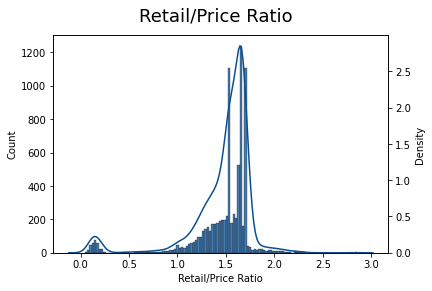

In [7]:
r = retail_cost_kde(training_df)

The above plot was a leftover from when I was experimenting with the retail/price ratio as a ranking variable. I thought the graph was particularly interesting because its bimodal. 

I remembered a video I saw some time ago about a professor who was identifying students in his class that cheated on the midterm exam and he mentioned that bimodal distributions typically occur when you have a gaussian event that is being impacted by an external asymmetric force (e.g. cheating).

In this instance I am sure there is not 'cheating' per se but I think the small retail/price values are the conflict diamonds. Just interesting to see this relationship expressed here.


#### Transcoding & Dummy Variables

In order to convert all the relevant data to numeric I had to create dummy variables for each of the fields where 2 > 1 didn't make sense (as in color, region, clarity and polish). The remaining categorical variables were transcoded on a scale from 1 - N. 

In converting Clarity to a numeric scale I used the following:
 - FL: 6
 - IF: 5
 - VVS1: 4.5
 - VVS2: 4
 - VS1: 3.5
 - VS2: 3 
 - SI1: 2.5
 - SI2: 2
 - I1: 1.5
 - I2: 1
 - I3: .5
 - pd.NA and " ": 0
 
I based it roughly on the ranking system I found [here](https://www.brilliantearth.com/diamond/buying-guide/clarity/).



In [8]:
ord_cols = ['Polish', 'Symmetry', 'Cut', 'Clarity']
cat_vars = ['Regions', 'Shape', 'Cert', 'Color']
orig_train = training_df.copy()
training_df = make_dummies(training_df, cols=cat_vars)

training_df = transcode_vars(training_df, cols=ord_cols)
training_df.dropna(axis=0, inplace=True)

For the analysis, in order to handle the objective of maximizing profit we need two models, the first would allow us to rank the diamonds that were most profitable then a second model would be used to create a bid price. 

When looking for the best ranking variable Y I went about testing several different transformations including cube root, log difference, retail/price ratio, etc. Honestly, there was a point when I thought I would need to construct the rank variable using a set of rules. However, the performance of the LogRetail model was fantastic so that ultimately wasn't necessary.

For my algorithm, I had seen online another person using a Random Forest Regressor but I thought this would be weak to edge cases so I built a Voting Regressor with the Random Forest model and a Gradient Boosting Regressor. The results were pretty stellar.


In [9]:
x_train_price, x_valid_price, y_train_price, y_valid_price = data_prep(df=training_df, y_col='LogPrice')
x_train_retail, x_valid_retail, y_train_retail, y_valid_retail = data_prep(df=training_df, y_col='LogRetail')


predicted_price, price_mod = fit_model(train_x=x_train_price, train_y=y_train_price, test_x=x_valid_price, test_y=y_valid_price, predict_type='LogPrice')
predicted_retail, retail_mod = fit_model(train_x=x_train_retail, train_y=y_train_retail, test_x=x_valid_retail, test_y=y_valid_retail, predict_type='LogRetail')





LogPrice Model

R-Squared: 0.9877961327664989
Correlation: 0.9938793351139257
MAE: 0.09600440377309269
MAPE: 0.01071548447149137


LogRetail Model

R-Squared: 0.9902859553295028
Correlation: 0.9951311246913659
MAE: 0.07857784731898033
MAPE: 0.008706345917298108


In [10]:
actpred_df = pd.DataFrame({'id': [_ for _ in predicted_price['id']],
                           "actual_price": [np.exp(_) for _  in y_valid_price],  
                           'actual_retail': [np.exp(_) for _  in y_valid_retail],
                           'predicted_price': [np.exp(_) for _  in predicted_price['LogPrice']],
                           'predicted_retail': [np.exp(_) for _  in predicted_retail['LogRetail']]})

print(actpred_df['predicted_price'].describe())


count       552.000000
mean      15285.910665
std       28709.156390
min         628.371010
25%        2846.995738
50%        7907.140207
75%       15652.987332
max      280811.430990
Name: predicted_price, dtype: float64


In [11]:
print("\n......................................")
print("No Price Limit, No Price Adjust")
print("......................................\n")
id0 = bid_math(actpred_df, 
               price_limit=False, 
               price_add=0)
print("\n......................................")
print("No Price Limit, 8K Price Adjust - Most Profit")
print("......................................\n")
id1 = bid_math(actpred_df,
               price_limit=False, 
               price_add=8000)
print("\n......................................\n")
print("24K Price Limit, No Price Adjust")
print("\n......................................\n")
id2 = bid_math(actpred_df,
               price_limit=True,
               price_add=0)
print("\n......................................\n")
print("24K Price Limit, 1K Price Adjust - Best Model")
print("\n......................................\n")
id3 = bid_math(actpred_df, 
               price_limit=True, 
               price_add=1000)





......................................
No Price Limit, No Price Adjust
......................................

Num Bids: 88 | Total Profit: 803151.1304650676 
#################
    Over-Bids:
	Count: 40
	Total: 132683.8695349435    
	Max: 12611.127326195448
	Min: 0
	Avg: 3317.096738373587    
#################
    Under-Bids:
	Count: 50
	Total: -433321.0195662687    
	Max: 0
	Min: -94613.56900972594
	Avg: -8666.420391325379

......................................
No Price Limit, 8K Price Adjust - Most Profit
......................................

Num Bids: 66 | Total Profit: 1225554.7017169253 
#################
    Over-Bids:
	Count: 58
	Total: 471140.29828306    
	Max: 20611.12732619545
	Min: 0
	Avg: 8123.10859108724    
#################
    Under-Bids:
	Count: 10
	Total: -215922.54275385977    
	Max: 0
	Min: -86613.56900972594
	Avg: -21592.254275385978

......................................

24K Price Limit, No Price Adjust

......................................

Num Bids: 472 

### Strategy 1: Diversification over Profit
When the price of the predicted values was limited, only 67 items were bid on and they were the most expensive ones. As we can see there is a huge gap between the max predicted price and the 75th percentile. So it seems reasonable that limiting the bids to diamonds with a predicted price <= 75th percentile is geared more towards diversification of assets rather than pure profit. Ultimately it seems it was a better way to go.

Also, I would imagine that larger diamonds are significantly more illiquid making them harder to find buyers for, as I explained in question 2.


### Strategy 2: Under-bid Minimization

The simplest way to reduce the number of under-bids is to add a fixed amount to every bid price although this is a blunt instrument it may be the best option when applying the data to a real test set where the actual prices aren't known. In this instance we could establish our added value by using the average under-bid amount to each of the bid prices. This resulted in a 4x reduction in the number of under-bids but the same number (predictably) became over-bids. Still we were able to improve the projected overall profit by almost 30%.



### Characteristics of Bids





<module 'matplotlib.pyplot' from '/home/dismas/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

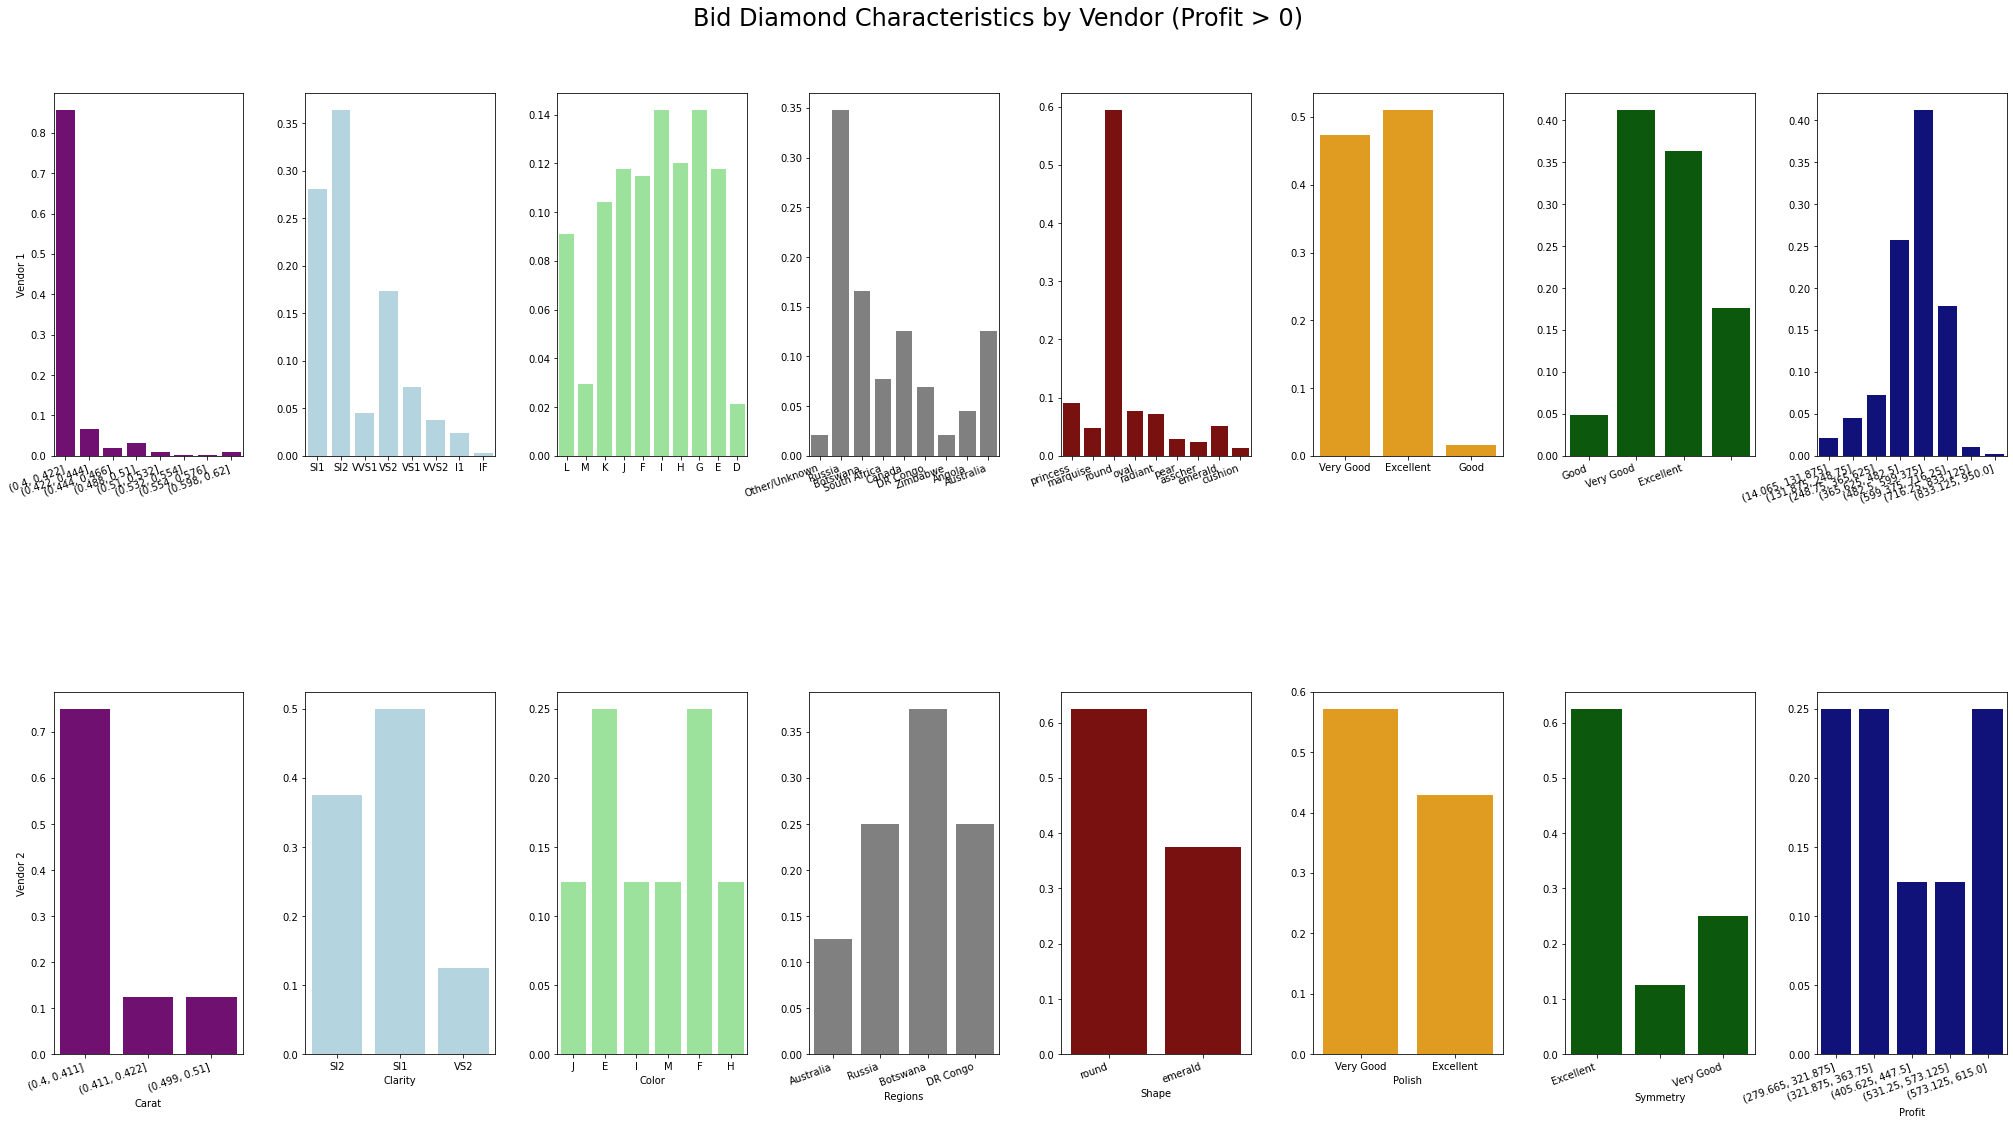

In [13]:
orig_train.insert(len(orig_train.columns), 'idx', orig_train.index)

vendor_charbars(orig_train[orig_train['idx'].isin(id3)], vendors=[1, 2], chars=8, max_profit=0, ttl="Bid Diamond Characteristics by Vendor (Profit > 0)")


Our bids were restricted to Vendor 1 and Vendor 2 due to the profitability of their diamonds. Here are the links to the [code](https://github.com/dtemkin/blog_resources/tree/master/diamond/code), [notebook](https://raw.githubusercontent.com/dtemkin/blog_resources/master/diamond/code/Analysis.ipynb) and [data](https://raw.githubusercontent.com/dtemkin/blog_resources/master/diamond/data/training.csv) for this project in case anyone is similarly interested in the project.